In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
livetime = [20,10,8,5,4,2,1] * u.h
n_obs = [50,100,125,200,250,500,1000]
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
model = []
for i in range(7):
    model_simu = ExpCutoffPowerLawSpectralModel(
        index=2.22,
        amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
        lambda_=2 * u.Unit("TeV-1"),
        alpha = 1,
    )
    print(model_simu) 
    mod = SkyModel(spectral_model=model_simu)
    model.append(mod)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    inde

In [6]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = []
for i in range(len(model)):
    obs.append(Observation.create(pointing=pointing, livetime=livetime[i], irfs=irfs))
    print(obs[i])

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 72000.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 36000.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 28800.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 18000.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 14400.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 7200.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 3600.0 s



In [8]:
dataset = []
for i in range(len(model)):
    dataset_empty = SpectrumDataset.create(
        e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
    )
    maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
    dataset.append(maker.run(dataset_empty, obs[i]))

In [9]:
data = []
for i in range(len(model)):
    dataset[i].model = model[i]
    dataset[i].fake(random_state=42)
    print(dataset[i])
    data.append(dataset[i])

SpectrumDataset

    Name                            : 1 

    Total counts                    : 8444 
    Total predicted counts          : nan
    Total background counts         : 8462.25

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 7.20e+04 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : 4219 
    Total predicted counts          : nan
    Total background counts         : 4231.13

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 3.60e+04 s

    Number of total bins            : 9 
    Number of fit bins

In [10]:
data_onoff = []
for i in range(len(model)):
    dataset_onoff = SpectrumDatasetOnOff(
        aeff=data[i].aeff,
        edisp=data[i].edisp,
        models=model[i],
        livetime=livetime[i],
        acceptance=1,
        acceptance_off=5,
    )
    dataset_onoff.fake(background_model=data[i].background)
    print(dataset_onoff)
    data_onoff.append(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 12343 
    Total predicted counts          : 12309.25
    Total off counts                : 42255.00

    Total background counts         : 8451.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 2.00e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 6193 
    Total predicted counts          : 6133.72
    Total off counts                : 21023.00

    Total background counts         : 4204.60

    Effe

In [11]:
%%time
datas = []
for i in range(len(model)):
    datasets = []
    for idx in range(n_obs[i]):
        data_onoff[i].fake(random_state=idx, background_model=data[i].background)
        data_onoff[i].name = f"obs_{idx}"
        datasets.append(data_onoff[i].copy())
    datas.append(datasets)

CPU times: user 13.2 s, sys: 93.9 ms, total: 13.3 s
Wall time: 13.8 s


In [12]:
len(datas)
print(*datas[2], sep = "\n")

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 4869 
    Total predicted counts          : 4878.50
    Total off counts                : 16676.00

    Total background counts         : 3335.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 4795 
    Total predicted counts          : 4904.30
    Total off counts                : 16805.00

    Total background counts         : 3361.00



SpectrumDatasetOnOff

    Name                            : obs_12 

    Total counts                    : 4886 
    Total predicted counts          : 4886.10
    Total off counts                : 16714.00

    Total background counts         : 3342.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_13 

    Total counts                    : 4853 
    Total predicted counts          : 4935.90
    Total off counts                : 16963.00

    Total background counts         : 3392.60

SpectrumDatasetOnOff

    Name                            : obs_24 

    Total counts                    : 4989 
    Total predicted counts          : 4972.70
    Total off counts                : 17147.00

    Total background counts         : 3429.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_25 

    Total counts                    : 4873 
    Total predicted counts          : 4949.50
    Total off counts                : 17031.00

    Total background counts         : 3406.20

SpectrumDatasetOnOff

    Name                            : obs_38 

    Total counts                    : 4951 
    Total predicted counts          : 4933.30
    Total off counts                : 16950.00

    Total background counts         : 3390.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_39 

    Total counts                    : 5057 
    Total predicted counts          : 4899.30
    Total off counts                : 16780.00

    Total background counts         : 3356.00

SpectrumDatasetOnOff

    Name                            : obs_49 

    Total counts                    : 5107 
    Total predicted counts          : 4906.10
    Total off counts                : 16814.00

    Total background counts         : 3362.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_50 

    Total counts                    : 4922 
    Total predicted counts          : 4969.10
    Total off counts                : 17129.00

    Total background counts         : 3425.8


SpectrumDatasetOnOff

    Name                            : obs_65 

    Total counts                    : 4878 
    Total predicted counts          : 4909.70
    Total off counts                : 16832.00

    Total background counts         : 3366.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_66 

    Total counts                    : 4895 
    Total predicted counts          : 4931.10
    Total off counts                : 16939.00

    Total background counts         : 3387.8

SpectrumDatasetOnOff

    Name                            : obs_82 

    Total counts                    : 4881 
    Total predicted counts          : 4871.10
    Total off counts                : 16639.00

    Total background counts         : 3327.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_83 

    Total counts                    : 4910 
    Total predicted counts          : 4916.70
    Total off counts                : 16867.00

    Total background counts         : 3373.40

SpectrumDatasetOnOff

    Name                            : obs_102 

    Total counts                    : 4942 
    Total predicted counts          : 4943.30
    Total off counts                : 17000.00

    Total background counts         : 3400.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_103 

    Total counts                    : 4922 
    Total predicted counts          : 4914.90
    Total off counts                : 16858.00

    Total background counts         : 3371.

SpectrumDatasetOnOff

    Name                            : obs_122 

    Total counts                    : 4906 
    Total predicted counts          : 4923.10
    Total off counts                : 16899.00

    Total background counts         : 3379.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 8.00e+00 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_123 

    Total counts                    : 4900 
    Total predicted counts          : 4953.90
    Total off counts                : 17053.00

    Total background counts         : 3410.

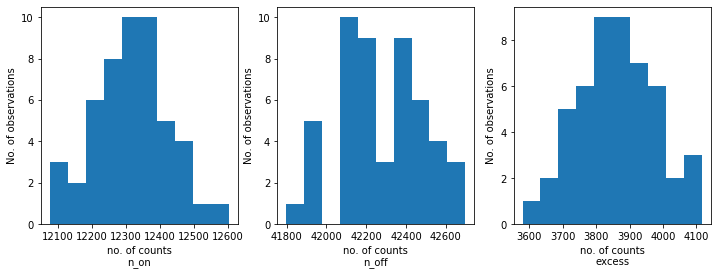

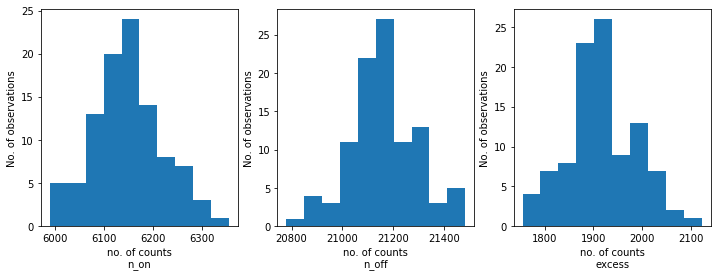

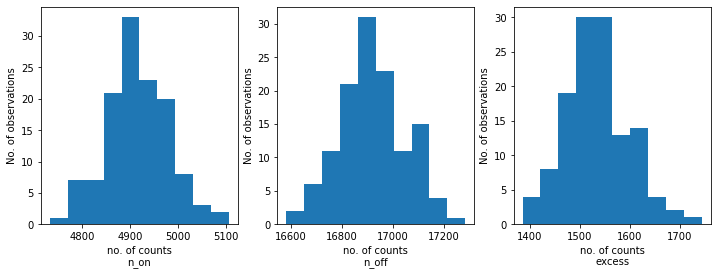

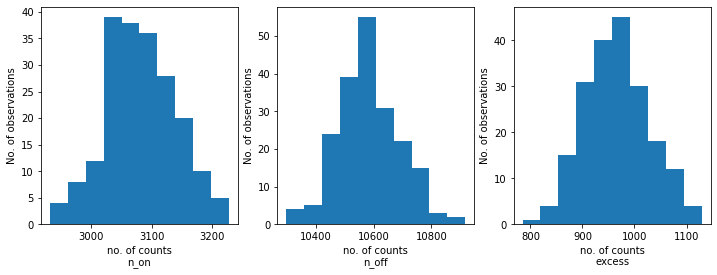

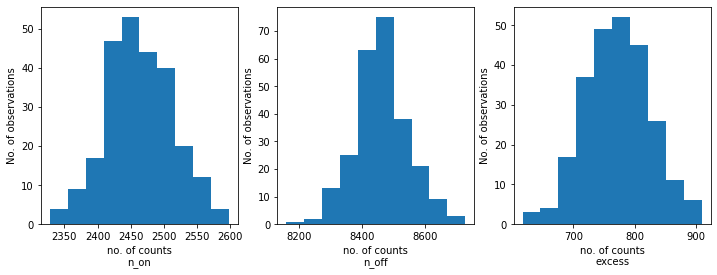

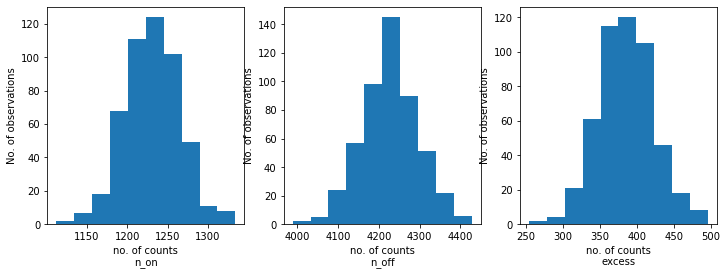

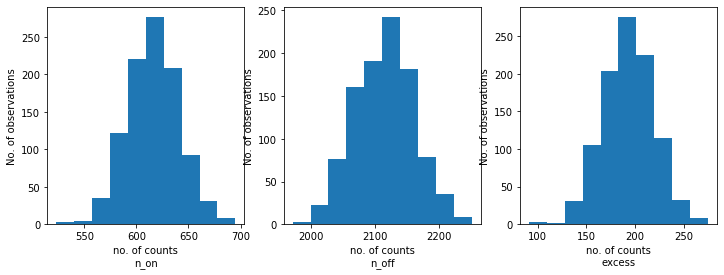

In [13]:
for i in range(7):
    n_on = [dataset.counts.data.sum() for dataset in datas[i]]
    n_off = [dataset.counts_off.data.sum() for dataset in datas[i]]
    excess = [dataset.excess.data.sum() for dataset in datas[i]]
    
    fix, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].hist(n_on)
    axes[0].set_xlabel("no. of counts\nn_on")
    axes[0].set_ylabel("No. of observations")
    axes[1].hist(n_off)
    axes[1].set_xlabel("no. of counts\nn_off")
    axes[1].set_ylabel("No. of observations")
    axes[2].hist(excess)
    axes[2].set_xlabel("no. of counts\nexcess");
    axes[2].set_ylabel("No. of observations")

In [14]:
%%time
res = []
for i in range(7):
    results = []
    for dataset in datas[i]:
        dataset.models = model[i].copy()
        fit = Fit([dataset])
        result = fit.optimize()
        results.append(
            {
                "index": result.parameters["index"].value,
                "amplitude": result.parameters["amplitude"].value,
                "lambda_": result.parameters["lambda_"].value,
                "reference":result.parameters["reference"].value,
                "alpha":result.parameters["alpha"].value,
            }
        )
        print(result.parameters.to_table())
    res.append(results)

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.243e+00   nan                nan nan  False
amplitude 1.151e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.624e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.243e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.974e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.378e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.189e+00   nan                nan nan  False
amplitude 1.373e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.138e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.089e+00   nan                nan nan  False
amplitude 1.795e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.509e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.285e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.184e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.997e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.129e+00   nan                nan nan  False
amplitude 1.540e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.354e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.365e+00   nan                nan nan  False
amplitude 8.968e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.252e+00   nan                nan nan  False
amplitude 1.091e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.699e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.225e+00   nan                nan nan  False
amplitude 1.286e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.090e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.350e+00   nan                nan nan  False
amplitude 7.773e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.125e+00   nan                nan nan  False
amplitude 1.718e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.304e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.101e+00   nan                nan nan  False
amplitude 1.625e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.178e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.097e+00   nan                nan nan  False
amplitude 1.891e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.235e+00   nan                nan nan  False
amplitude 1.211e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.894e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.124e+00   nan                nan nan  False
amplitude 1.679e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.383e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.860e+00   nan                nan nan  False
amplitude 3.700e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.232e+00   nan                nan nan  False
amplitude 1.192e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.758e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.246e+00   nan                nan nan  False
amplitude 1.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.459e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.503e+00   nan                nan nan  False
amplitude 6.153e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.960e+00   nan                nan nan  False
amplitude 2.558e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.111e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.969e+00   nan                nan nan  False
amplitude 2.764e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.365e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.191e+00   nan                nan nan  False
amplitude 1.319e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.043e+00   nan                nan nan  False
amplitude 2.283e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.866e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.000e+00   nan                nan nan  False
amplitude 2.150e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.669e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.089e+00   nan                nan nan  False
amplitude 1.753e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.245e+00   nan                nan nan  False
amplitude 1.371e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.109e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.406e+00   nan                nan nan  False
amplitude 8.140e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.470e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.249e+00   nan                nan nan  False
amplitude 1.200e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.116e+00   nan                nan nan  False
amplitude 1.594e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.287e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.147e+00   nan                nan nan  False
amplitude 1.653e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.053e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.320e+00   nan                nan nan  False
amplitude 9.897e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.910e+00   nan                nan nan  False
amplitude 3.014e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.258e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.165e+00   nan                nan nan  False
amplitude 1.554e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.387e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.113e+00   nan                nan nan  False
amplitude 1.822e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.345e+00   nan                nan nan  False
amplitude 9.236e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.663e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.227e+00   nan                nan nan  False
amplitude 1.247e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.903e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.341e+00   nan                nan nan  False
amplitude 8.973e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.132e+00   nan                nan nan  False
amplitude 1.523e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.100e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.064e+00   nan                nan nan  False
amplitude 1.945e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.651e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.192e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.200e+00   nan                nan nan  False
amplitude 1.365e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.858e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.438e+00   nan                nan nan  False
amplitude 7.824e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.280e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.155e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.259e+00   nan                nan nan  False
amplitude 1.252e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.007e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.191e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.038e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.126e+00   nan                nan nan  False
amplitude 1.550e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.129e+00   nan                nan nan  False
amplitude 1.812e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.293e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.991e+00   nan                nan nan  False
amplitude 2.278e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.629e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.344e+00   nan                nan nan  False
amplitude 8.439e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.321e+00   nan                nan nan  False
amplitude 9.295e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.464e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.096e+00   nan                nan nan  False
amplitude 2.142e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.872e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.120e+00   nan                nan nan  False
amplitude 1.682e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.305e+00   nan                nan nan  False
amplitude 1.036e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.779e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.153e+00   nan                nan nan  False
amplitude 1.559e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.396e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.226e+00   nan                nan nan  False
amplitude 1.215e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.229e+00   nan                nan nan  False
amplitude 1.216e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.060e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.040e+00   nan                nan nan  False
amplitude 2.153e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.719e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.175e+00   nan                nan nan  False
amplitude 1.427e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.085e+00   nan                nan nan  False
amplitude 1.808e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.773e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 1.439e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.251e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.058e+00   nan                nan nan  False
amplitude 2.002e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.002e+00   nan                nan nan  False
amplitude 2.425e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.054e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.288e+00   nan                nan nan  False
amplitude 1.046e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.550e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.454e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.265e+00   nan                nan nan  False
amplitude 1.173e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.811e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.244e+00   nan                nan nan  False
amplitude 1.345e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.476e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.285e+00   nan                nan nan  False
amplitude 1.110e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.086e+00   nan                nan nan  False
amplitude 1.852e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.508e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.589e+00   nan                nan nan  False
amplitude 4.648e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.865e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.260e+00   nan                nan nan  False
amplitude 1.291e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.306e+00   nan                nan nan  False
amplitude 1.070e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.774e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.117e+00   nan                nan nan  False
amplitude 1.904e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.189e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.134e+00   nan                nan nan  False
amplitude 1.816e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.443e+00   nan                nan nan  False
amplitude 6.340e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.280e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.136e+00   nan                nan nan  False
amplitude 1.415e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.947e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.179e+00   nan                nan nan  False
amplitude 1.451e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.929e+00   nan                nan nan  False
amplitude 2.685e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.608e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.024e+00   nan                nan nan  False
amplitude 2.078e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.539e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.092e+00   nan                nan nan  False
amplitude 1.660e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.450e+00   nan                nan nan  False
amplitude 6.861e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.041e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.933e+00   nan                nan nan  False
amplitude 2.332e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.534e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.150e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.558e+00   nan                nan nan  False
amplitude 5.812e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.040e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.254e+00   nan                nan nan  False
amplitude 1.378e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.138e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.241e+00   nan                nan nan  False
amplitude 1.260e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.083e+00   nan                nan nan  False
amplitude 1.927e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.640e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.007e+00   nan                nan nan  False
amplitude 2.384e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.821e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.096e+00   nan                nan nan  False
amplitude 1.898e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.261e+00   nan                nan nan  False
amplitude 1.020e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.086e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.073e+00   nan                nan nan  False
amplitude 1.705e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.819e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.458e+00   nan                nan nan  False
amplitude 7.926e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.453e+00   nan                nan nan  False
amplitude 7.097e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.284e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.368e+00   nan                nan nan  False
amplitude 8.665e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.549e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.162e+00   nan                nan nan  False
amplitude 1.872e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.546e+00   nan                nan nan  False
amplitude 5.798e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.128e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.027e+00   nan                nan nan  False
amplitude 1.907e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.278e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.002e+00   nan                nan nan  False
amplitude 2.145e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.289e+00   nan                nan nan  False
amplitude 1.133e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.790e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.290e+00   nan                nan nan  False
amplitude 1.189e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.844e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.193e+00   nan                nan nan  False
amplitude 1.253e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.352e+00   nan                nan nan  False
amplitude 9.180e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.431e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.280e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.999e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.383e+00   nan                nan nan  False
amplitude 9.381e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.532e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.515e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.623e+00   nan                nan nan  False
amplitude 4.441e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.551e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.912e+00   nan                nan nan  False
amplitude 2.127e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.152e+00   nan                nan nan  False
amplitude 2.175e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.917e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.278e+00   nan                nan nan  False
amplitude 1.262e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.661e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.091e+00   nan                nan nan  False
amplitude 1.998e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.421e+00   nan                nan nan  False
amplitude 6.987e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.125e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.173e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.823e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.988e+00   nan                nan nan  False
amplitude 2.111e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.808e+00   nan                nan nan  False
amplitude 4.746e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.804e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.744e+00   nan                nan nan  False
amplitude 4.577e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.677e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.067e+00   nan                nan nan  False
amplitude 1.828e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.517e+00   nan                nan nan  False
amplitude 5.919e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.312e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.338e+00   nan                nan nan  False
amplitude 8.614e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.242e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.174e+00   nan                nan nan  False
amplitude 1.442e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.112e+00   nan                nan nan  False
amplitude 1.914e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.593e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.361e+00   nan                nan nan  False
amplitude 1.083e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.447e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.543e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.223e+00   nan                nan nan  False
amplitude 8.898e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.235e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.535e+00   nan                nan nan  False
amplitude 6.494e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.302e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.505e+00   nan                nan nan  False
amplitude 6.029e-13   nan cm-2 s-1 TeV-1 nan nan

/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:196: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C ** 2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index       nan   nan                nan nan  False
amplitude       nan   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_       nan   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.272e+00   nan                nan nan  False
amplitude 2.124e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.388e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.916e+00   nan                nan nan  False
amplitude 2.516e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.161e+00   nan                nan nan  False
amplitude 1.717e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.344e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.202e+00   nan                nan nan  False
amplitude 1.431e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.098e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.138e+00   nan                nan nan  False
amplitude 1.538e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.030e+00   nan                nan nan  False
amplitude 1.843e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.091e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.131e+00   nan                nan nan  False
amplitude 1.549e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.316e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.749e+00   nan                nan nan  False
amplitude 5.392e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.149e+00   nan                nan nan  False
amplitude 1.826e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.895e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.286e+00   nan                nan nan  False
amplitude 1.071e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.867e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.097e+00   nan                nan nan  False
amplitude 2.033e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.498e+00   nan                nan nan  False
amplitude 6.984e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.972e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.644e+00   nan                nan nan  False
amplitude 7.324e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.080e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.456e+00   nan                nan nan  False
amplitude 8.718e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.106e+00   nan                nan nan  False
amplitude 1.397e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.731e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.714e+00   nan                nan nan  False
amplitude 3.594e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.096e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.837e+00   nan                nan nan  False
amplitude 3.780e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.487e+00   nan                nan nan  False
amplitude 5.885e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.083e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.397e+00   nan                nan nan  False
amplitude 6.771e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.092e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.174e+00   nan                nan nan  False
amplitude 1.597e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.089e+00   nan                nan nan  False
amplitude 2.219e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.758e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.282e+00   nan                nan nan  False
amplitude 1.543e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.490e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.079e+00   nan                nan nan  False
amplitude 2.287e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.741e+00   nan                nan nan  False
amplitude 2.965e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.781e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.156e+00   nan                nan nan  False
amplitude 1.379e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.853e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.402e+00   nan                nan nan  False
amplitude 9.261e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.818e+00   nan                nan nan  False
amplitude 3.891e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.995e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.679e+00   nan                nan nan  False
amplitude 6.546e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.178e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.934e+00   nan                nan nan  False
amplitude 3.628e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.337e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.030e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.407e+00   nan                nan nan  False
amplitude 1.168e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.140e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.207e+00   nan                nan nan  False
amplitude 1.308e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.918e+00   nan                nan nan  False
amplitude 2.974e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.451e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.606e+00   nan                nan nan  False
amplitude 6.566e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.802e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.853e+00   nan                nan nan  False
amplitude 1.906e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.783e+00   nan                nan nan  False
amplitude 2.537e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.292e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.789e+00   nan                nan nan  False
amplitude 4.055e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.962e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.763e+00   nan                nan nan  False
amplitude 4.850e-12   nan cm-2 s-1 TeV-1 nan nan

/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  6.688e+00   nan                nan nan  False
amplitude -3.698e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -7.768e+00   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.201e+00   nan                nan nan  False
amplitude 1.357e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.558e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.994e+00   nan                nan nan  False
amplitude 2.786e-12   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.320e+00   nan                nan nan  False
amplitude 1.319e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.543e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.068e+00   nan                nan nan  False
amplitude 2.092e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.280e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.511e+00   nan                nan nan  False
amplitude 5.748e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.899e+00   nan                nan nan  False
amplitude 3.606e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.783e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.811e+00   nan                nan nan  False
amplitude 3.658e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.678e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.886e+00   nan                nan nan  False
amplitude 3.869e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.303e+00   nan                nan nan  False
amplitude 1.059e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.112e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.330e+00   nan                nan nan  False
amplitude 8.367e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.105e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.183e+00   nan                nan nan  False
amplitude 1.625e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.144e+00   nan                nan nan  False
amplitude 1.613e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.069e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.472e+00   nan                nan nan  False
amplitude 8.825e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.910e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.762e+00   nan                nan nan  False
amplitude 4.270e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.074e+00   nan                nan nan  False
amplitude 1.646e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.950e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.803e+00   nan                nan nan  False
amplitude 3.040e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.912e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.873e+00   nan                nan nan  False
amplitude 4.391e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.461e+00   nan                nan nan  False
amplitude 6.294e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.541e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.390e+00   nan                nan nan  False
amplitude 7.420e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.083e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.716e+00   nan                nan nan  False
amplitude 2.892e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.363e+00   nan                nan nan  False
amplitude 9.757e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.239e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.233e+00   nan                nan nan  False
amplitude 1.132e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.188e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.639e+00   nan                nan nan  False
amplitude 7.842e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.727e+00   nan                nan nan  False
amplitude 5.077e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.149e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.480e+00   nan                nan nan  False
amplitude 5.019e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.114e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.058e+00   nan                nan nan  False
amplitude 1.789e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.273e+00   nan                nan nan  False
amplitude 1.190e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.644e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.182e+00   nan                nan nan  False
amplitude 1.425e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.523e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.318e+00   nan                nan nan  False
amplitude 2.403e-11   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 7.753e-01   nan                nan nan  False
amplitude 1.590e-10   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.351e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 9.679e-01   nan                nan nan  False
amplitude 3.875e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 7.612e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.512e+00   nan                nan nan  False
amplitude 4.713e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.449e+00   nan                nan nan  False
amplitude 8.123e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.043e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.926e+00   nan                nan nan  False
amplitude 4.566e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.430e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 5.619e-01   nan                nan nan  False
amplitude 2.211e-10   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.683e+00   nan                nan nan  False
amplitude 5.233e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.459e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.366e+00   nan                nan nan  False
amplitude 7.640e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.403e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.174e+00   nan                nan nan  False
amplitude 1.556e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.411e+00   nan                nan nan  False
amplitude 9.207e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.395e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.089e+00   nan                nan nan  False
amplitude 1.820e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.232e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.880e+00   nan                nan nan  False
amplitude  1.894e-13   nan cm-2 s-1 TeV-1 nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.187e+00   nan                nan nan  False
amplitude 1.342e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.287e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.452e+00   nan                nan nan  False
amplitude 1.432e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.870e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.399e+00   nan                nan nan  False
amplitude 1.414e-11   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.786e+00   nan                nan nan  False
amplitude 4.515e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.671e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.119e+00   nan                nan nan  False
amplitude 1.879e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.416e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.631e+00   nan                nan nan  False
amplitude 4.263e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 4.641e-01   nan                nan nan  False
amplitude 1.398e-10   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.422e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.086e+00   nan                nan nan  False
amplitude 2.090e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.574e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.074e+00   nan                nan nan  False
amplitude 1.689e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.178e+00   nan                nan nan  False
amplitude 2.397e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.326e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.321e+00   nan                nan nan  False
amplitude 9.671e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.516e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.061e+00   nan                nan nan  False
amplitude 1.506e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.387e+00   nan                nan nan  False
amplitude 1.002e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.766e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.309e+00   nan                nan nan  False
amplitude 9.416e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.088e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.485e+00   nan                nan nan  False
amplitude 8.879e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.662e+00   nan                nan nan  False
amplitude 4.295e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.246e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.885e+00   nan                nan nan  False
amplitude 2.656e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.182e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.586e+00   nan                nan nan  False
amplitude 5.145e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.772e+00   nan                nan nan  False
amplitude 4.350e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.365e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.087e+00   nan                nan nan  False
amplitude 1.526e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.028e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.405e+00   nan                nan nan  False
amplitude 8.695e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.028e+00   nan                nan nan  False
amplitude 1.826e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.399e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.270e+00   nan                nan nan  False
amplitude 1.316e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.621e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.103e+00   nan                nan nan  False
amplitude 1.679e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.348e+00   nan                nan nan  False
amplitude 8.041e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.125e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.103e+00   nan                nan nan  False
amplitude 1.618e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.023e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.287e+00   nan                nan nan  False
amplitude 9.695e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.778e+00   nan                nan nan  False
amplitude 4.853e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.299e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.568e+00   nan                nan nan  False
amplitude 5.406e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.280e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 3.734e-01   nan                nan nan  False
amplitude 2.903e-10   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.124e+00   nan                nan nan  False
amplitude 1.700e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.624e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.156e+00   nan                nan nan  False
amplitude 1.356e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.308e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.615e+00   nan                nan nan  False
amplitude 5.884e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.449e+00   nan                nan nan  False
amplitude 6.597e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.314e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.746e+00   nan                nan nan  False
amplitude 3.980e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.885e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.992e+00   nan                nan nan  False
amplitude 2.194e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.615e+00   nan                nan nan  False
amplitude 6.476e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.296e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 7.408e-01   nan                nan nan  False
amplitude 7.639e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.114e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.264e+00   nan                nan nan  False
amplitude 1.234e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.956e+00   nan                nan nan  False
amplitude 2.531e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.541e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.807e+00   nan                nan nan  False
amplitude 3.591e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.862e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.971e+00   nan                nan nan  False
amplitude 2.300e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.198e+00   nan                nan nan  False
amplitude 1.452e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.331e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.447e+00   nan                nan nan  False
amplitude 1.072e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.719e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.600e+00   nan                nan nan  False
amplitude 7.901e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.230e+00   nan                nan nan  False
amplitude 1.230e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.849e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.702e+00   nan                nan nan  False
amplitude 4.568e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.761e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.838e+00   nan                nan nan  False
amplitude 2.917e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.159e+00   nan                nan nan  False
amplitude 1.550e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.002e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.247e+00   nan                nan nan  False
amplitude 1.415e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.758e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.600e+00   nan                nan nan  False
amplitude 3.958e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.993e+00   nan                nan nan  False
amplitude 2.197e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.890e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.356e+00   nan                nan nan  False
amplitude 1.005e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.582e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.047e+00   nan                nan nan  False
amplitude 1.605e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.448e+00   nan                nan nan  False
amplitude 7.150e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.467e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.902e+00   nan                nan nan  False
amplitude 2.437e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.818e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.427e+00   nan                nan nan  False
amplitude 8.315e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.742e+00   nan                nan nan  False
amplitude 3.292e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.250e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.552e+00   nan                nan nan  False
amplitude 5.256e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.608e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.445e+00   nan                nan nan  False
amplitude 6.949e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.501e+00   nan                nan nan  False
amplitude 6.585e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.897e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.918e+00   nan                nan nan  False
amplitude 2.536e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.354e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.378e+00   nan                nan nan  False
amplitude 1.282e-11   nan cm-2 s-1 TeV-1 nan nan

   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
    index  2.624e+00   nan                nan nan  False
amplitude  2.736e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference  1.000e+00   nan            TeV nan nan   True
  lambda_ -5.496e-03   nan          TeV-1 nan nan  False
    alpha  1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 8.745e-01   nan                nan nan  False
amplitude 1.599e-10   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.575e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.515e+00   nan                nan nan  False
amplitude 5.836e-13   nan cm-2 s-1 TeV-1 

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.212e+00   nan                nan nan  False
amplitude 1.570e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.272e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.817e+00   nan                nan nan  False
amplitude 3.724e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 4.706e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.107e+00   nan                nan nan  False
amplitude 1.690e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.594e+00   nan                nan nan  False
amplitude 6.634e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.829e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.559e+00   nan                nan nan  False
amplitude 5.097e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.320e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.685e+00   nan                nan nan  False
amplitude 4.583e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.164e+00   nan                nan nan  False
amplitude 1.443e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.067e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.666e+00   nan                nan nan  False
amplitude 4.558e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.686e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.920e+00   nan                nan nan  False
amplitude 2.601e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.620e+00   nan                nan nan  False
amplitude 3.553e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.696e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.247e+00   nan                nan nan  False
amplitude 2.227e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.843e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.827e+00   nan                nan nan  False
amplitude 2.637e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.098e+00   nan                nan nan  False
amplitude 2.754e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 6.852e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.567e+00   nan                nan nan  False
amplitude 5.429e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 8.489e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.002e+00   nan                nan nan  False
amplitude 2.151e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.870e+00   nan                nan nan  False
amplitude 4.653e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.593e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.238e+00   nan                nan nan  False
amplitude 1.231e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.007e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.980e+00   nan                nan nan  False
amplitude 2.993e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.120e+00   nan                nan nan  False
amplitude 1.512e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.389e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.838e+00   nan                nan nan  False
amplitude 3.166e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.489e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.175e+00   nan                nan nan  False
amplitude 1.961e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.650e+00   nan                nan nan  False
amplitude 4.575e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.875e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.268e+00   nan                nan nan  False
amplitude 1.139e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.489e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.165e+00   nan                nan nan  False
amplitude 1.482e-11   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.391e+00   nan                nan nan  False
amplitude 9.911e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.530e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.645e+00   nan                nan nan  False
amplitude 5.978e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.224e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.107e+00   nan                nan nan  False
amplitude 2.512e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.119e+00   nan                nan nan  False
amplitude 2.144e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.399e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.647e+00   nan                nan nan  False
amplitude 3.314e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.370e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.196e+00   nan                nan nan  False
amplitude 9.000e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.486e+00   nan                nan nan  False
amplitude 9.025e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.211e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.589e+00   nan                nan nan  False
amplitude 4.812e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.575e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.147e+00   nan                nan nan  False
amplitude 1.105e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.026e+00   nan                nan nan  False
amplitude 2.382e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.229e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.850e+00   nan                nan nan  False
amplitude 2.344e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.539e-03   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.186e+00   nan                nan nan  False
amplitude 1.671e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.079e+00   nan                nan nan  False
amplitude 2.764e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.031e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.802e+00   nan                nan nan  False
amplitude 3.526e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.214e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.449e+00   nan                nan nan  False
amplitude 8.352e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.306e+00   nan                nan nan  False
amplitude 1.652e-11   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.205e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.472e+00   nan                nan nan  False
amplitude 6.594e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.896e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.649e+00   nan                nan nan  False
amplitude 4.670e-13   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 3.937e-01   nan                nan nan  False
amplitude 3.988e-10   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.369e+01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.844e+00   nan                nan nan  False
amplitude 2.877e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.952e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.704e+00   nan                nan nan  False
amplitude 8.005e-12   nan cm-2 s-1 TeV-1 nan nan

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 1.763e+00   nan                nan nan  False
amplitude 4.158e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.765e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.336e+00   nan                nan nan  False
amplitude 1.101e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.862e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.625e-12   nan cm-2 s-1 TeV-1 nan nan

In [15]:
import scipy.stats as stats
import math

In [16]:
index = []
amplitude = []
lambda_ = []
reference = []
alpha = []
covar = []
for i in range(7):
    a = np.array([_["index"] for _ in res[i]])
    b = np.array([_["amplitude"] for _ in res[i]])
    c = np.array([_["reference"] for _ in res[i]])
    d = np.array([_["lambda_"] for _ in res[i]])
    e = np.array([_["alpha"] for _ in res[i]])
    index.append(a)
    amplitude.append(b)
    reference.append(c)
    lambda_.append(d)
    alpha.append(e)
    
mu = [0,0,0,0,0,0,0]
sigma = [0,0,0,0,0,0,0]
np_hist = [0,0,0,0,0,0,0]
for i in range(7):
    x = np.array([index[i], amplitude[i], reference[i], lambda_[i], alpha[i]])
    covar.append(np.cov(x))

index: 2.2135175170665473 += 0.08703082711414678
index: 2.198654229018978 += 0.1251834417467993
index: 2.184231118886255 += 0.1325498526648501
index: 2.2015660637591457 += 0.1717012601260155
index: 2.2037241150115086 += 0.19715054022232315


/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


index: nan += nan
index: nan += nan


/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6743: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6744: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

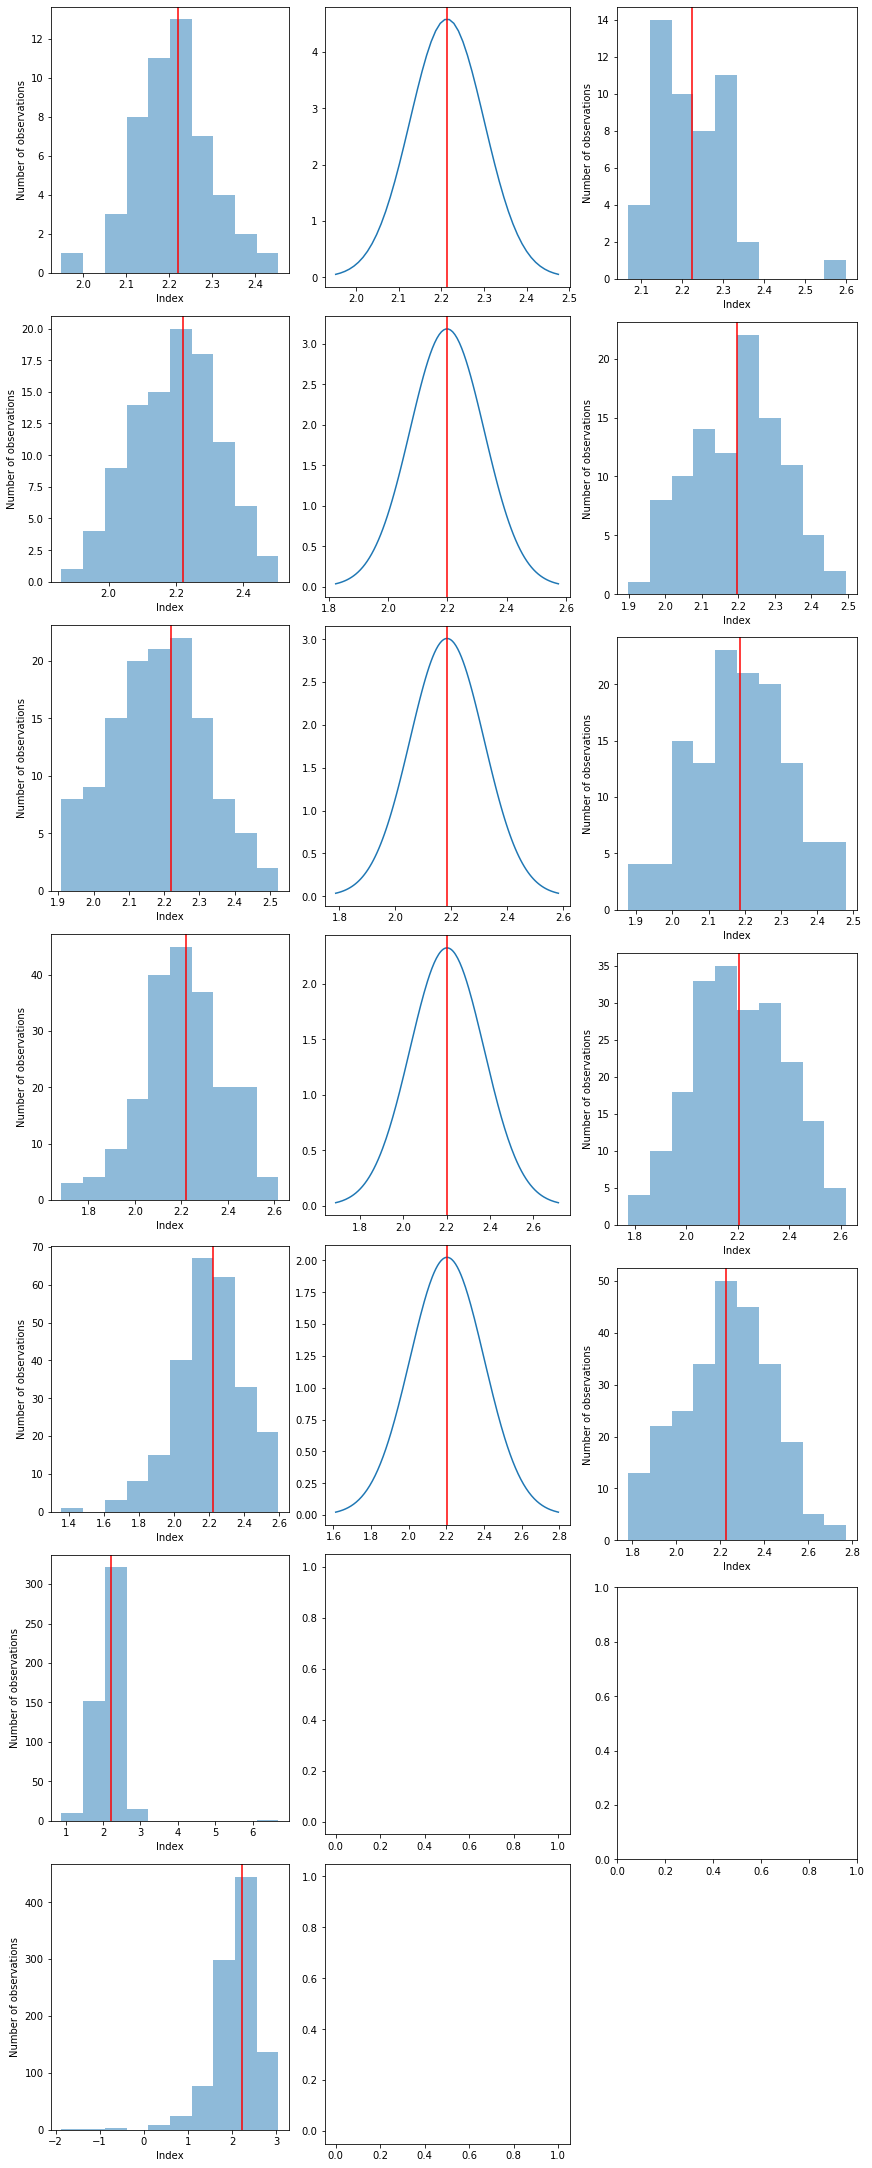

In [17]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[0])
for n in range(7):
    ax = fig.add_subplot(gs1[n])
    plt.hist(index[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["index"].value, color="red")
    plt.xlabel("Index")
    plt.ylabel("Number of observations")
    print(f"index: {index[n].mean()} += {index[n].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[1])
for n in range(7):
    ax = fig.add_subplot(gs2[n])
    mu[n] = index[n].mean()
    sigma[n] = index[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs[n])
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[2])
for n in range(7):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=np_hist[n].mean(), color="red")
    plt.xlabel('Index')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[3])
for n in range(7):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(index[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["index"].value, color="green")
    plt.xlabel('Index')
    plt.ylabel('Number of observations')
    

plt.show()

In [ ]:
plt.scatter(np.log10(n_obs), mu, label= "stars", color= "green",  
            marker= "*", s=30)    
plt.xlabel('n_obs')
plt.ylabel('index_mean')
plt.ylim(min(mu),max(mu))
plt.show()

In [ ]:
plt.scatter(np.log10(n_obs), sigma, label= "stars", color= "green",  
            marker= "*", s=30)    
plt.xlabel('n_obs') 
plt.ylabel('index_std') 
plt.ylim(min(sigma),max(sigma))
plt.show()  

In [ ]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[0])
for n in range(7):
    ax = fig.add_subplot(gs1[n])
    plt.hist(amplitude[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
    plt.xlabel("amplitude")
    plt.ylabel("Number of observations")
    print(f"amplitude: {amplitude[n].mean()} += {amplitude[n].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[1])
for n in range(7):
    ax = fig.add_subplot(gs2[n])
    mu[n] = amplitude[n].mean()
    sigma[n] = amplitude[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs[n])
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[2])
for n in range(7):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=np_hist[n].mean(), color="red")
    plt.xlabel('amplitude')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[3])
for n in range(7):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(amplitude[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["amplitude"].value, color="green")
    plt.xlabel('amplitude')
    plt.ylabel('Number of observations')
    

plt.show()

In [ ]:
plt.scatter(np.log10(n_obs), mu, label= "stars", color= "green",  
            marker= "*", s=30)    
plt.xlabel('n_obs')
plt.ylabel('amplitude_mean')
plt.ylim(min(mu),max(mu))
plt.show() 

In [ ]:
plt.scatter(np.log10(n_obs), sigma, label= "stars", color= "green",  
            marker= "*", s=30)    
plt.xlabel('n_obs') 
plt.ylabel('amplitude_std') 
plt.ylim(min(sigma),max(sigma))
plt.show() 

In [ ]:
fig = plt.figure(figsize=[16,30],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 4, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[0])
for n in range(7):
    ax = fig.add_subplot(gs1[n])
    plt.hist(lambda_[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
    plt.xlabel("lambda_")
    plt.ylabel("Number of observations")
    print(f"lambda_: {lambda_[n].mean()} += {lambda_[n].std()}")
    
gs2 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[1])
for n in range(7):
    ax = fig.add_subplot(gs2[n])
    mu[n] = lambda_[n].mean()
    sigma[n] = lambda_[n].std()
    x = np.linspace(mu[n] - 3*sigma[n], mu[n] + 3*sigma[n], n_obs[n])
    plt.plot(x, stats.norm.pdf(x, mu[n], sigma[n]))
    plt.axvline(x=mu[n], color="red")

gs3 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[2])
for n in range(7):
    ax = fig.add_subplot(gs3[n])
    np_hist[n] = np.random.normal(loc=mu[n], scale=sigma[n], size=n_obs[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.axvline(x=np_hist[n].mean(), color="red")
    plt.xlabel('lambda_')
    plt.ylabel('Number of observations')
    
gs4 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[3])    
for n in range(7):
    ax = fig.add_subplot(gs4[n])
    plt.hist(x=np_hist[n], bins=10, alpha=0.5)
    plt.hist(lambda_[n], bins=10, alpha=0.5)
    plt.axvline(x=model_simu.parameters["lambda_"].value, color="green")
    plt.xlabel('lambda_')
    plt.ylabel('Number of observations')
    

plt.show()

In [ ]:
plt.scatter(np.log10(n_obs), mu, label= "stars", color= "green",  
            marker= "*", s=30)    
plt.xlabel('n_obs')
plt.ylabel('lambda_mean')
plt.ylim(min(mu),max(mu))
plt.show() 

In [ ]:
plt.scatter(np.log10(n_obs), sigma, label= "stars", color= "green",  
            marker= "*", s=30)    
plt.xlabel('n_obs') 
plt.ylabel('lambda_std') 
plt.ylim(min(sigma),max(sigma))
plt.show() 

In [ ]:
sim = [] 
for i in range(7):
    s = ExpCutoffPowerLawSpectralModel(
        index=index[i].mean(),
        amplitude=amplitude[i].mean() * u.Unit("cm-2 s-1 TeV-1"),
        reference=1 * u.TeV,
        lambda_=lambda_[i].mean() * u.Unit("TeV-1"),
        alpha = 1,
    )
    print(s)
    sim.append(s)

In [ ]:
plt.figure(figsize=[16,8])
energy_range = [0.03, 100] * u.TeV
for i in range(7):
    sim[i].plot(energy_range)
plt.show

In [ ]:
def evaluate_err(self, covar, energy, epsilon=1e-4):

        p_cov = covar
        eps = np.sqrt(np.diag(covar)) * epsilon

        df_dp = self._evaluate_gradient(energy, eps)
        f_cov = df_dp.T @ p_cov @ df_dp
        f_err = np.sqrt(np.diagonal(f_cov))

        q = self(energy)
        return u.Quantity([q.value, f_err], unit=q.unit)

In [ ]:
def plot_error(
        self,
        covar,
        energy_range,
        ax=None,
        energy_unit="TeV",
        flux_unit="cm-2 s-1 TeV-1",
        energy_power=0,
        n_points=100,
        **kwargs,
    ):
        
        ax = plt.gca() if ax is None else ax

        kwargs.setdefault("facecolor", "black")
        kwargs.setdefault("alpha", 0.2)
        kwargs.setdefault("linewidth", 0)

        emin, emax = energy_range
        energy = MapAxis.from_energy_bounds(emin, emax, n_points, energy_unit).edges

        flux, flux_err = evaluate_err(self,covar,energy).to(flux_unit)

        y_lo = self._plot_scale_flux(energy, flux - flux_err, energy_power)
        y_hi = self._plot_scale_flux(energy, flux + flux_err, energy_power)

        where = (energy >= energy_range[0]) & (energy <= energy_range[1])
        ax.fill_between(energy.value, y_lo.value, y_hi.value, where=where, **kwargs)

        self._plot_format_ax(ax, energy, y_lo, energy_power)
        return ax

In [ ]:
fig = plt.figure(figsize=[16,16],constrained_layout=True)

import matplotlib.gridspec as gridspec

gs0 = gridspec.GridSpec(1, 3, figure=fig)

gs1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0])
for n in range(2):
    ax = fig.add_subplot(gs1[n])
    sim[n].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n], covar=covar[n],energy_range=energy_range, energy_power=2)

gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[1])
for n in range(3):
    ax = fig.add_subplot(gs2[n])
    sim[n+2].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+2], covar=covar[n+2],energy_range=energy_range, energy_power=2)

gs3 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[2])
for n in range(2):
    ax = fig.add_subplot(gs3[n])
    sim[n+5].plot(energy_range=energy_range, energy_power=2)
    plot_error(self=sim[n+5], covar=covar[n+5],energy_range=energy_range, energy_power=2)
    

plt.show()